# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)
7. [Evaluate](#evaluate)
7. [Metrics](#metrics)
8. [Plots](#plots)

<a name=imports></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import preprocessing

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


***
<a name=data></a>
## Data

### Ingestion
Load in the dataset as pandas dataframe.

In [3]:
# Check preprocessing.py for implementation
(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df) = preprocessing.ingestion()

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True
India Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-01-30        NaN     NaN        NaN
1  2020-01-31        0.0     0.0        0.0
2  2020-02-01        0.0     0.0        0.0
3  2020-02-02        1.0     0.0        0.0
4  2020-02-03        1.0     0.0        0.0 

India Vacc:
          Date  Total_Doses
0  2020-01-30          0.0
1  2020-01-31          0.0
2  2020-02-01          0.0
3  2020-02-02          0.0
4  2020-02-03          0.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-12        NaN     NaN        NaN
1  2020-04-13    25255.0  1542.0    11785.0
2  2020-04-14    26694.0  2327.0     6484.0
3  2020-04-15    29318.0  2474.0     6093.0
4  2020-04-16    31235.0  4607.0     5234.0 

USA Vacc:
          Date  Total_Doses
0  2020-04-12          0.0
1  2020-04-13          0.0
2  2020-04-14          0.0
3  2020-

### Pre-Processing
Filter out unnecessary columns. 

#### Multivariate

In [4]:
# Check preprocessing.py for implementation
# Number of Null in India - 563
# Number of Null in USA - 261
(india_multi, usa_multi) = preprocessing.multivariate(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df)

India:
          Date  Confirmed  Total_Doses
0  2020-01-30        NaN          0.0
1  2020-01-31        0.0          0.0
2  2020-02-01        0.0          0.0
3  2020-02-02        1.0          0.0
4  2020-02-03        1.0          0.0
USA:
          Date  Confirmed  Total_Doses
0  2020-04-12        NaN          0.0
1  2020-04-13    25255.0          0.0
2  2020-04-14    26694.0          0.0
3  2020-04-15    29318.0          0.0
4  2020-04-16    31235.0          0.0


#### Univariate 

In [5]:
# Check preprocessing.py for implementation
# Number of Null in India - 0
# Number of Null in USA - 0
(india_cases_uni, usa_cases_uni) = preprocessing.univariate(india_cases_df, usa_cases_df)

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    25255.0
2    26694.0
3    29318.0
4    31235.0
5    32175.0 



### Drop Null
Merging the vaccination and #cases datasets together for multivariate time series produces null values. Dropping the nuWe solve this by dropping the null values.ll values ensures that we take an inner join.

In [6]:
(india_multi, usa_multi) = preprocessing.dropNull(india_multi, usa_multi)

India:
          Date  Confirmed  Total_Doses
1  2020-01-31        0.0          0.0
2  2020-02-01        0.0          0.0
3  2020-02-02        1.0          0.0
4  2020-02-03        1.0          0.0
5  2020-02-04        0.0          0.0
USA:
          Date  Confirmed  Total_Doses
1  2020-04-13    25255.0          0.0
2  2020-04-14    26694.0          0.0
3  2020-04-15    29318.0          0.0
4  2020-04-16    31235.0          0.0
5  2020-04-17    32175.0          0.0


### Normalize
Perform a Z-score normalization.

In [7]:
# Check preprocessing.py for implementation
(india_uni_norm, usa_uni_norm, india_multi_norm, usa_multi_norm,india_cases_mean,india_cases_std,usa_cases_mean,usa_cases_std,india_multi_mean,india_multi_std,
usa_multi_mean, usa_multi_std) = preprocessing.normalize(india_cases_uni, 
                                                                                           usa_cases_uni, 
                                                                                           india_multi, 
                                                                                           usa_multi)

India Cases univariate:
    Confirmed
1  -0.662416
2  -0.662416
3  -0.662403
4  -0.662403
5  -0.662416 

USA Cases univariate:
    Confirmed
1  -0.596456
2  -0.584433
3  -0.562508
4  -0.546491
5  -0.538637 

India Cases multivariate:
    Confirmed  Total_Doses
1  -0.662416    -0.627946
2  -0.662416    -0.627946
3  -0.662403    -0.627946
4  -0.662403    -0.627946
5  -0.662416    -0.627946 

USA Cases multivariate:
    Confirmed  Total_Doses
1  -0.596456    -0.932844
2  -0.584433    -0.932844
3  -0.562508    -0.932844
4  -0.546491    -0.932844
5  -0.538637    -0.932844 



### Create Splits
Break the dataset into train and test. The current split is 80:20.

In [8]:
# Create train test splits
(india_uni_train, india_uni_test, usa_uni_train, usa_uni_test) = preprocessing.split(india_uni_norm, usa_uni_norm, 0.2)
(india_multi_train, india_multi_test, 
 usa_multi_train, usa_multi_test) = preprocessing.split(india_multi_norm, usa_multi_norm, 0.2)

India:
      Confirmed
1    -0.662416
2    -0.662416
3    -0.662403
4    -0.662403
5    -0.662416
..         ...
564  -0.332037
565  -0.200599
566  -0.184543
567  -0.182312
568  -0.210064

[568 rows x 1 columns] 

USA:
      Confirmed
1    -0.596456
2    -0.584433
3    -0.562508
4    -0.546491
5    -0.538637
..         ...
507   0.882933
508   0.655423
509   1.161010
510  -0.188293
511  -0.412010

[511 rows x 1 columns] 

India:
      Confirmed  Total_Doses
1    -0.662416    -0.627946
2    -0.662416    -0.627946
3    -0.662403    -0.627946
4    -0.662403    -0.627946
5    -0.662416    -0.627946
..         ...          ...
564  -0.332037     0.649820
565  -0.200599     0.663746
566  -0.184543     0.676817
567  -0.182312     0.687132
568  -0.210064     0.702473

[568 rows x 2 columns] 

USA:
      Confirmed  Total_Doses
1    -0.596456    -0.932844
2    -0.584433    -0.932844
3    -0.562508    -0.932844
4    -0.546491    -0.932844
5    -0.538637    -0.932844
..         ...          ...
50

### Data Transformation
Simple conversion from pandas dataframe to numpy array by extracting the values.

In [9]:
# Univariate
india_uni_train_np, india_uni_test_np = india_uni_train.values,  india_uni_test.values
usa_uni_train_np, usa_uni_test_np = usa_uni_train.values, usa_uni_test.values
# Multivariate
india_multi_train_np, india_multi_test_np = india_multi_train.values,  india_multi_test.values
usa_multi_train_np, usa_multi_test_np = usa_multi_train.values, usa_multi_test.values

In [10]:
print(india_uni_train_np.shape, india_uni_test_np.shape)
print(india_multi_train_np.shape, india_multi_test_np.shape)

(568, 1) (143, 1)
(568, 2) (143, 2)


### Reshape
Converts the exiting train data set to match the input parameters of an LSTM (Samples, Time Steps, Features). The `lstm_data_transform()` method takes in 3 arguments: X data, y data and number of features.

We will be performing autoregression on the univariate data, therefore the X and y values are the same. As for the multivariate data, we will be using the confirmed column (index 0) as the y value.

In [11]:
india_uni_train_np

array([[-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62403204e-01],
       [-6.62403204e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62390076e-01],
       [-6.62416332e-01],
       [-6.62114388e-01],
       [-6.62390076e-01],
       [-6.62403204e-01],
       [-6.62376948e-01],
       [-6.62350692e-01],
       [-6.6

In [12]:
timesteps = 14

In [13]:
# Univariate
india_uni_train_X, india_uni_train_y = preprocessing.lstm_data_transform(india_uni_train_np, india_uni_train_np,
                                                                         timesteps)
usa_uni_train_X, usa_uni_train_y = preprocessing.lstm_data_transform(usa_uni_train_np, usa_uni_train_np,
                                                                     timesteps)
# Multivariate
india_multi_train_X, india_multi_train_y = preprocessing.lstm_data_transform(india_multi_train_np, india_multi_train_np, timesteps)
usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np, timesteps)

In [14]:
print("Univariate India shape:",india_uni_train_X.shape, india_uni_train_y.shape)
print("Multivariate India shape:",india_multi_train_X.shape, india_multi_train_y.shape)

Univariate India shape: (554, 14, 1) (554, 1)
Multivariate India shape: (554, 14, 2) (554, 2)


The univariate array shape for the India dataset has 566 samples, 3 as the time step, and 1 feature for the X values. The y values is just the 566 samples.

Similarly, the multivariate array shape for the India dataset has 276 samples, 3 as the time step, and 2 features for the X values. The y values is just the 276 samples of the 0th column (Confirmed cases).

***
<a name=model></a>
## Model
We will define 4 models in total. One for the univariate data and another for the multivariate for each country.

In [15]:
import LSTMmodels
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [16]:
univariate_model_ind = LSTMmodels.build_lstm(time_steps=india_uni_train_X.shape[1],
                                             features=india_uni_train_X.shape[2])
univariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_uni_train_X.shape[1],
                                             features=usa_uni_train_X.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
______________________________

In [17]:
multivariate_model_ind = LSTMmodels.build_lstm(time_steps=india_multi_train_X.shape[1],
                                               features=india_multi_train_X.shape[2], outputs=2)
multivariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_multi_train_X.shape[1],
                                               features=usa_multi_train_X.shape[2], outputs=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 43,262
Trainable params: 43,262
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
____________________________

***
<a name=train></a>
## Train 

In [18]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [20]:
# Train the model on univariate India dataset 
univariate_model_ind = LSTMmodels.train_model(univariate_model_ind,india_uni_train_X,india_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 2s 33ms/step - loss: 0.4950 - mae: 0.4950
Epoch 2/300
18/18 [==============================] - 0s 12ms/step - loss: 0.2485 - mae: 0.2485
Epoch 3/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1487 - mae: 0.1487
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1398 - mae: 0.1398
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1260 - mae: 0.1260
Epoch 6/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1070 - mae: 0.1070
Epoch 7/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0971 - mae: 0.0971
Epoch 8/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1084 - mae: 0.1084
Epoch 9/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0917 - mae: 0.0917
Epoch 10/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0815 - mae: 0.0815
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 12ms/step - loss: 0.0521 - mae: 0.0521
Epoch 87/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0546 - mae: 0.0546
Epoch 88/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0492 - mae: 0.0492
Epoch 89/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0486 - mae: 0.0486
Epoch 90/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0499 - mae: 0.0499
Epoch 91/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0525 - mae: 0.0525
Epoch 92/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0530 - mae: 0.0530
Epoch 93/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0499 - mae: 0.0499
Epoch 94/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0523 - mae: 0.0523
Epoch 95/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0496 - mae: 0.0496
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 12ms/step - loss: 0.0454 - mae: 0.0454
Epoch 171/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0471 - mae: 0.0471
Epoch 172/300
18/18 [==============================] - 0s 11ms/step - loss: 0.0478 - mae: 0.0478
Epoch 173/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0519 - mae: 0.0519
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0488 - mae: 0.0488
Epoch 175/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0450 - mae: 0.0450
Epoch 176/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0449 - mae: 0.0449
Epoch 177/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0477 - mae: 0.0477
Epoch 178/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0442 - mae: 0.0442
Epoch 179/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0466 - mae: 0.0466
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 14ms/step - loss: 0.0467 - mae: 0.0467
Epoch 255/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0419 - mae: 0.0419
Epoch 256/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0419 - mae: 0.0419
Epoch 257/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0421 - mae: 0.0421
Epoch 258/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0417 - mae: 0.0417
Epoch 259/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0439 - mae: 0.0439
Epoch 260/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0494 - mae: 0.0494
Epoch 261/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0420 - mae: 0.0420
Epoch 262/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0415 - mae: 0.0415
Epoch 263/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0425 - mae: 0.0425
Epoch 264/300
18/18 [=======================

In [21]:
# Train the model on univariate USA dataset 
univariate_model_usa = LSTMmodels.train_model(univariate_model_usa,usa_uni_train_X,usa_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 33ms/step - loss: 0.3862 - mae: 0.3862
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 0.2077 - mae: 0.2077
Epoch 3/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1514 - mae: 0.1514
Epoch 4/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1391 - mae: 0.1391
Epoch 5/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1358 - mae: 0.1358
Epoch 6/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1340 - mae: 0.1340
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1344 - mae: 0.1344
Epoch 8/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1300 - mae: 0.1300
Epoch 9/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1350 - mae: 0.1350
Epoch 10/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1275 - mae: 0.1275
Epoch 11/300
16/16 [=============================

16/16 [==============================] - 0s 13ms/step - loss: 0.0686 - mae: 0.0686
Epoch 87/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0689 - mae: 0.0689
Epoch 88/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0711 - mae: 0.0711
Epoch 89/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0686 - mae: 0.0686
Epoch 90/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0723 - mae: 0.0723
Epoch 91/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0733 - mae: 0.0733
Epoch 92/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0715 - mae: 0.0715
Epoch 93/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0734 - mae: 0.0734
Epoch 94/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0712 - mae: 0.0712
Epoch 95/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0736 - mae: 0.0736
Epoch 96/300
16/16 [==============================] -

16/16 [==============================] - 0s 12ms/step - loss: 0.0530 - mae: 0.0530
Epoch 171/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0596 - mae: 0.0596
Epoch 172/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0539 - mae: 0.0539
Epoch 173/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0549 - mae: 0.0549
Epoch 174/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0552 - mae: 0.0552
Epoch 175/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0524 - mae: 0.0524
Epoch 176/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0521 - mae: 0.0521
Epoch 177/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0524 - mae: 0.0524
Epoch 178/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0519 - mae: 0.0519
Epoch 179/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0518 - mae: 0.0518
Epoch 180/300
16/16 [=======================

16/16 [==============================] - 0s 13ms/step - loss: 0.0422 - mae: 0.0422
Epoch 255/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0424 - mae: 0.0424
Epoch 256/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0440 - mae: 0.0440
Epoch 257/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0421 - mae: 0.0421
Epoch 258/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0433 - mae: 0.0433
Epoch 259/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0477 - mae: 0.0477
Epoch 260/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0472 - mae: 0.0472
Epoch 261/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0449 - mae: 0.0449
Epoch 262/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0455 - mae: 0.0455
Epoch 263/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0419 - mae: 0.0419
Epoch 264/300
16/16 [=======================

In [22]:
# Train the model on multivariate India dataset
multivariate_model_ind = LSTMmodels.train_model(multivariate_model_ind,india_multi_train_X,india_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 1s 29ms/step - loss: 0.4980 - mae: 0.4980
Epoch 2/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1912 - mae: 0.1912
Epoch 3/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0989 - mae: 0.0989
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0774 - mae: 0.0774
Epoch 5/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0727 - mae: 0.0727
Epoch 6/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0701 - mae: 0.0701
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0686 - mae: 0.0686
Epoch 8/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0608 - mae: 0.0608
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0603 - mae: 0.0603
Epoch 10/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0541 - mae: 0.0541
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 12ms/step - loss: 0.0371 - mae: 0.0371
Epoch 87/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0332 - mae: 0.0332
Epoch 88/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0326 - mae: 0.0326
Epoch 89/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0338 - mae: 0.0338
Epoch 90/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.0317
Epoch 91/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0357 - mae: 0.0357
Epoch 92/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0344 - mae: 0.0344
Epoch 93/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0328 - mae: 0.0328
Epoch 94/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0308 - mae: 0.0308
Epoch 95/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0319 - mae: 0.0319
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 13ms/step - loss: 0.0316 - mae: 0.0316
Epoch 171/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0279 - mae: 0.0279
Epoch 172/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0276 - mae: 0.0276
Epoch 173/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0260 - mae: 0.0260
Epoch 174/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0284 - mae: 0.0284
Epoch 175/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0284 - mae: 0.0284
Epoch 176/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0286 - mae: 0.0286
Epoch 177/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0283 - mae: 0.0283
Epoch 178/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0280 - mae: 0.0280
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0307 - mae: 0.0307
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 13ms/step - loss: 0.0272 - mae: 0.0272
Epoch 255/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0283 - mae: 0.0283
Epoch 256/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0255 - mae: 0.0255
Epoch 257/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0252 - mae: 0.0252
Epoch 258/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0253 - mae: 0.0253
Epoch 259/300
18/18 [==============================] - 0s 11ms/step - loss: 0.0243 - mae: 0.0243
Epoch 260/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0257 - mae: 0.0257
Epoch 261/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0245 - mae: 0.0245
Epoch 262/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0246 - mae: 0.0246
Epoch 263/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0262 - mae: 0.0262
Epoch 264/300
18/18 [=======================

In [23]:
# Train the model on multivariate USA dataset
multivariate_model_usa = LSTMmodels.train_model(multivariate_model_usa,usa_multi_train_X,usa_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 35ms/step - loss: 0.5274 - mae: 0.5274
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 0.2202 - mae: 0.2202
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1131 - mae: 0.1131
Epoch 4/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0943 - mae: 0.0943
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0858 - mae: 0.0858
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0825 - mae: 0.0825
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0755 - mae: 0.0755
Epoch 8/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0746 - mae: 0.0746
Epoch 9/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0757 - mae: 0.0757
Epoch 10/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0755 - mae: 0.0755
Epoch 11/300
16/16 [=============================

16/16 [==============================] - 0s 13ms/step - loss: 0.0430 - mae: 0.0430
Epoch 87/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0433 - mae: 0.0433
Epoch 88/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0462 - mae: 0.0462
Epoch 89/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0456 - mae: 0.0456
Epoch 90/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0471 - mae: 0.0471
Epoch 91/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0475 - mae: 0.0475
Epoch 92/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0418 - mae: 0.0418
Epoch 93/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0452 - mae: 0.0452
Epoch 94/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0444 - mae: 0.0444
Epoch 95/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0443 - mae: 0.0443
Epoch 96/300
16/16 [==============================] -

16/16 [==============================] - 0s 12ms/step - loss: 0.0380 - mae: 0.0380
Epoch 171/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0424 - mae: 0.0424
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0421 - mae: 0.0421
Epoch 173/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0375 - mae: 0.0375
Epoch 174/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0363 - mae: 0.0363
Epoch 175/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0380 - mae: 0.0380
Epoch 176/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0399 - mae: 0.0399
Epoch 177/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0373 - mae: 0.0373
Epoch 178/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0357 - mae: 0.0357
Epoch 179/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0372 - mae: 0.0372
Epoch 180/300
16/16 [=======================

16/16 [==============================] - 0s 12ms/step - loss: 0.0307 - mae: 0.0307
Epoch 255/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0323 - mae: 0.0323
Epoch 256/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0314 - mae: 0.0314
Epoch 257/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0306 - mae: 0.0306
Epoch 258/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0338 - mae: 0.0338
Epoch 259/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0342 - mae: 0.0342
Epoch 260/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0316 - mae: 0.0316
Epoch 261/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0318 - mae: 0.0318
Epoch 262/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0323 - mae: 0.0323
Epoch 263/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0335 - mae: 0.0335
Epoch 264/300
16/16 [=======================

***
<a name=predict></a>
## Predict
There are 2 different types of prediction methods. 
1. Long-term predictions

This type of prediction uses a sliding window to continue to predict into the future by continuing to use the forecasted values.

2. Rolling short-term predictions

This prediction method continues to train the LSTM model every 14 iterations. Unlike the long-term predictions, this model forecasts one day at a time.

In [24]:
import evaluate

#### Long-Term 

In [25]:
# Univariate Long-Term
yhat_uni_india = evaluate.make_predictions(univariate_model_ind,india_uni_test_np,timesteps,india_uni_test_np.shape[1])
yhat_uni_usa = evaluate.make_predictions(univariate_model_usa,usa_uni_test_np,timesteps,usa_uni_test_np.shape[1])

In [26]:
# Multivariate Long-Term 
yhat_multi_india_long = evaluate.make_predictions(multivariate_model_ind,india_multi_test_np,timesteps,india_multi_test_np.shape[1])
yhat_multi_usa_long = evaluate.make_predictions(multivariate_model_usa,usa_multi_test_np,timesteps,usa_multi_test_np.shape[1])

#### Rolling Short-Term 

In [27]:
# Univariate Rolling Short-Term
yhat_uni_india_short, y_uni_india_short, univariate_model_ind = evaluate.make_predictions_short(univariate_model_ind,
                                                                                                india_uni_train_np,
                                                                                                india_uni_test_np,timesteps,
                                                                                                india_uni_test_np.shape[1],
                                                                                               tensorboard_callback)
yhat_uni_usa_short, y_uni_usa_short, univariate_model_usa = evaluate.make_predictions_short(univariate_model_usa, 
                                                                                            usa_uni_train_np,
                                                                                            usa_uni_test_np,timesteps,
                                                                                            usa_uni_test_np.shape[1],
                                                                                           tensorboard_callback)

Epoch 1/10
18/18 [==============================] - 1s 30ms/step - loss: 0.0376 - mae: 0.0376
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0420 - mae: 0.0420
Epoch 3/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0377 - mae: 0.0377
Epoch 4/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0384 - mae: 0.0384
Epoch 5/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0383 - mae: 0.0383
Epoch 6/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0376 - mae: 0.0376
Epoch 7/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0382 - mae: 0.0382
Epoch 8/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0412 - mae: 0.0412
Epoch 9/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0425 - mae: 0.0425
Epoch 10/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0420 - mae: 0.0420
Epoch 1/10
18/18 [==============================] - 0s 27ms

21/21 [==============================] - 0s 13ms/step - loss: 0.0353 - mae: 0.0353
Epoch 9/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0329 - mae: 0.0329
Epoch 10/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0354 - mae: 0.0354
Epoch 1/10
22/22 [==============================] - 1s 25ms/step - loss: 0.0344 - mae: 0.0344
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0349 - mae: 0.0349
Epoch 3/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0367 - mae: 0.0367
Epoch 4/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0335 - mae: 0.0335
Epoch 5/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0310 - mae: 0.0310
Epoch 6/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0342 - mae: 0.0342
Epoch 7/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0314 - mae: 0.0314
Epoch 8/10
22/22 [==============================] - 0s 12ms/step - los

19/19 [==============================] - 0s 13ms/step - loss: 0.0562 - mae: 0.0562
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0516 - mae: 0.0516
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0572 - mae: 0.0572
Epoch 8/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0529 - mae: 0.0529
Epoch 9/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0505 - mae: 0.0505
Epoch 10/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0551 - mae: 0.0551
Epoch 1/10
19/19 [==============================] - 0s 26ms/step - loss: 0.0578 - mae: 0.0578
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0552 - mae: 0.0552
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 0.0540 - mae: 0.0540
Epoch 4/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0538 - mae: 0.0538
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - los

In [28]:
# Multivariate Rolling Short-Term
yhat_multi_india, y_multi_india_short, multivariate_model_ind = evaluate.make_predictions_short(multivariate_model_ind, india_multi_train_np,india_multi_test_np,timesteps,
                                                                                                india_multi_test_np.shape[1],
                                                                                               tensorboard_callback, india_multi_test_np.shape[0])
yhat_multi_usa, y_multi_india_short, multivariate_model_usa = evaluate.make_predictions_short(multivariate_model_usa,usa_multi_train_np,usa_multi_test_np,
                                                                      timesteps,usa_multi_test_np.shape[1],
                                                                     tensorboard_callback, usa_multi_test_np.shape[0])

Epoch 1/10
18/18 [==============================] - 1s 29ms/step - loss: 0.0243 - mae: 0.0243
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0241 - mae: 0.0241
Epoch 3/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0239 - mae: 0.0239
Epoch 4/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0243 - mae: 0.0243
Epoch 5/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0233 - mae: 0.0233
Epoch 6/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0241 - mae: 0.0241
Epoch 7/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0237 - mae: 0.0237
Epoch 8/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0244 - mae: 0.0244
Epoch 9/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0241 - mae: 0.0241
Epoch 10/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0244 - mae: 0.0244
Epoch 1/10
18/18 [==============================] - 0s 26ms

21/21 [==============================] - 0s 13ms/step - loss: 0.0245 - mae: 0.0245
Epoch 9/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0231 - mae: 0.0231
Epoch 10/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0227 - mae: 0.0227
Epoch 1/10
22/22 [==============================] - 1s 25ms/step - loss: 0.0218 - mae: 0.0218
Epoch 2/10
22/22 [==============================] - 0s 11ms/step - loss: 0.0252 - mae: 0.0252
Epoch 3/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0255 - mae: 0.0255
Epoch 4/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0242 - mae: 0.0242
Epoch 5/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0222 - mae: 0.0222
Epoch 6/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0234 - mae: 0.0234
Epoch 7/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0230 - mae: 0.0230
Epoch 8/10
22/22 [==============================] - 0s 12ms/step - los

19/19 [==============================] - 0s 12ms/step - loss: 0.0418 - mae: 0.0418
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0412 - mae: 0.0412
Epoch 7/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0410 - mae: 0.0410
Epoch 8/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0420 - mae: 0.0420
Epoch 9/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0434 - mae: 0.0434
Epoch 10/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0411 - mae: 0.0411
Epoch 1/10
19/19 [==============================] - 0s 26ms/step - loss: 0.0439 - mae: 0.0439
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0446 - mae: 0.0446
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0441 - mae: 0.0441
Epoch 4/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0437 - mae: 0.0437
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - los

In [29]:
# print(yhat_multi_india)
# print(yhat_multi_usa.shape)
yhat_multi_india = np.concatenate(yhat_multi_india).flatten()
print(yhat_multi_india)
yhat_multi_usa = np.concatenate(yhat_multi_usa).flatten()
print(yhat_multi_usa)

# yhat_multi_india = yhat_multi_india[0]
# yhat_multi_usa = yhat_multi_usa[0]
yhat_multi_india_long = yhat_multi_india_long[0]
yhat_multi_usa_long = yhat_multi_usa_long[0]

[-0.29267865  0.7182186  -0.45043164  0.72410226 -0.47757626  0.73520315
 -0.329858    0.752771   -0.29550117  0.7650481  -0.30726355  0.77874106
 -0.3430863   0.79279184 -0.42999548  0.80885816 -0.6308156   0.8096585
 -0.6110475   0.8260178  -0.4349013   0.8530535  -0.420556    0.8687253
 -0.45913166  0.88879174 -0.5630215   0.9086218  -0.17870747  0.98338175
 -0.22454391  1.0111884  -0.22499882  1.0257602  -0.14328216  1.0208962
 -0.10795377  1.0359603  -0.10227953  1.0626589  -0.1065235   1.0863844
 -0.1066681   1.1106942  -0.11920677  1.1381915  -0.20846175  1.1912574
 -0.1292225   1.1893371  -0.10379671  1.2092605  -0.1050273   1.2414868
 -0.1223297   1.276949   -0.25995544  1.2458701  -0.2850819   1.2760146
 -0.34722474  1.3157434  -0.307817    1.3314185  -0.2814851   1.3586466
 -0.338563    1.404717   -0.35773185  1.438787   -0.40464786  1.4802659
 -0.4239054   1.5098021  -0.4489031   1.5373304  -0.44485095  1.5565472
 -0.42328075  1.5749009  -0.39815333  1.596487   -0.39284328 

In [30]:
print(yhat_multi_india.shape,
yhat_multi_usa.shape,
yhat_multi_india_long.shape,
yhat_multi_usa_long.shape)

(286,) (256,) (286, 2) (256, 2)


***
<a name=evaluate></a>
## Evaluate

### Denormalize Data
First step is to denormalize the data back to it's original scale.

#### Long-Term 

##### Univariate 

In [31]:
# Denormalize univariate India data
india_uni_test_np_denorm = preprocessing.de_normalize(india_uni_test_np.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_denorm = preprocessing.de_normalize(yhat_uni_india.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))

# Round values to avoid floating point errors
india_uni_test_np_long_denorm = np.round(india_uni_test_np_denorm)
yhat_uni_india_long_denorm = np.round(yhat_uni_india_denorm)

In [32]:
# Denormalize univariate USA data
usa_uni_test_np_denorm = preprocessing.de_normalize(usa_uni_test_np.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_denorm = preprocessing.de_normalize(yhat_uni_usa.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))

# Round values to avoid floating point errors
usa_uni_test_np_long_denorm = np.round(usa_uni_test_np_denorm)
yhat_uni_usa_long_denorm = np.round(yhat_uni_usa_denorm)

##### Multivariate

In [33]:
# Denormalize multivariate India data - long term
india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[:,0].flatten()[0::2][timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

# Round values to avoid floating point errors
india_multi_test_np_long_denorm = np.round(india_multi_test_np_long_denorm)
yhat_multi_india_long_denorm = np.round(yhat_multi_india_long_denorm)

In [34]:
# Denormalize multivariate USA data - long term
usa_multi_test_np_long_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_long_denorm = preprocessing.de_normalize(yhat_multi_usa_long[:,0].flatten()[0::2][timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

# Round values to avoid floating point errors
usa_multi_test_np_long_denorm = np.round(usa_multi_test_np_long_denorm)
yhat_multi_usa_long_denorm = np.round(yhat_multi_usa_long_denorm)

#### Rolling Short-Term 

In [35]:
yhat_multi_india_long[0]

array([-0.25613042,  0.70980816])

##### Univariate 

In [36]:
# Reshaping the data to standard dim 1
yhat_uni_india_short = np.concatenate(yhat_uni_india_short).flatten()

# Denormalize univariate short India data
india_uni_test_short_denorm = preprocessing.de_normalize(y_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_short_denorm = preprocessing.de_normalize(yhat_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))

# Round values to avoid floating point errors
india_uni_test_short_denorm = np.round(india_uni_test_short_denorm)
yhat_uni_india_short_denorm = np.round(yhat_uni_india_short_denorm)

In [37]:
# Reshaping the data to standard dim 1
yhat_uni_usa_short = np.concatenate(yhat_uni_usa_short).flatten()

# Denormalize univariate short USA data
usa_uni_test_short_denorm = preprocessing.de_normalize(y_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_short_denorm = preprocessing.de_normalize(yhat_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))

# Round values to avoid floating point errors
usa_uni_test_short_denorm = np.round(usa_uni_test_short_denorm)
yhat_uni_usa_short_denorm = np.round(yhat_uni_usa_short_denorm)

##### Multivariate

In [38]:
# Denormalize multivariate India data - short term
india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

# Round values to avoid floating point errors
india_multi_test_np_short_denorm = np.round(india_multi_test_np_denorm)
yhat_multi_india_short_denorm = np.round(yhat_multi_india_denorm)[0::2]

In [39]:
# Denormalize multivariate USA data - short term
usa_multi_test_np_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa.flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

# Round values to avoid floating point errors
usa_multi_test_np_short_denorm = np.round(usa_multi_test_np_denorm)
yhat_multi_usa_short_denorm = np.round(yhat_multi_usa_denorm)[0::2]

***
<a name=metrics></a>
## Get Metrics 
Return format: (mape, mae, rmse)

#### Long-Term

In [40]:
# Check to ensure data matches
denorm_test = evaluate.evaluate(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm)
denorm_test

[0.0, 0.0, 0.0]

##### Univariate

In [41]:
# Univariate Long-Term India
uni_india_eval_long = evaluate.evaluate(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm)
uni_india_eval_long.insert(0,'Univariate Long-Term India')
uni_india_eval_long

['Univariate Long-Term India', 8216783093760.0, 275780.40625, 436751.1]

In [42]:
# Univariate Long-Term USA
uni_usa_eval_long = evaluate.evaluate(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm)
uni_usa_eval_long.insert(0,'Univariate Long-Term USA')
uni_usa_eval_long

['Univariate Long-Term USA', 142.42857360839844, 161127.8125, 253260.23]

##### Multivariate

In [43]:
# Multivariate Long-Term India
multi_india_eval_long = evaluate.evaluate(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm)
multi_india_eval_long.insert(0,'Multivariate Long-Term India')
multi_india_eval_long

['Multivariate Long-Term India', nan, nan, nan]

In [44]:
# Multivariate Long-Term USA
multi_usa_eval_long = evaluate.evaluate(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm)
multi_usa_eval_long.insert(0,'Multivariate Long-Term USA')
multi_usa_eval_long

['Multivariate Long-Term USA', 118.66635131835938, 142130.734375, 246501.5]

#### Short-Term Rolling Forecast

##### Univariate 

In [45]:
# Univariate Short-Term India
uni_india_eval_short = evaluate.evaluate(india_uni_test_short_denorm, yhat_uni_india_short_denorm)
uni_india_eval_short.insert(0,'Univariate Short-Term India')
uni_india_eval_short

['Univariate Short-Term India', 117566431232.0, 4342.783203125, 11109.812]

In [46]:
# Univariate Short-Term USA
uni_usa_eval_short = evaluate.evaluate(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm)
uni_usa_eval_short.insert(0,'Univariate Short-Term USA')
uni_usa_eval_short

['Univariate Short-Term USA', 40.510108947753906, 76601.9453125, 168203.16]

##### Multivariate

In [47]:
# Multivariate Short-Term India
multi_india_eval_short = evaluate.evaluate(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm)
multi_india_eval_short.insert(0,'Multivariate Short-Term India')
multi_india_eval_short

['Multivariate Short-Term India', 129286720000.0, 9851.615, 21865.436]

In [48]:
# Multivariate Short-Term USA
multi_usa_eval_short = evaluate.evaluate(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm)
multi_usa_eval_short.insert(0,'Multivariate Short-Term USA')
multi_usa_eval_short

['Multivariate Short-Term USA', 49.13476, 78297.94, 131966.77]

### Visualize performance
TODO: Still need to add multivariate metrics

In [49]:
d = [uni_india_eval_long,uni_usa_eval_long,uni_india_eval_short,uni_usa_eval_short,multi_india_eval_long,
    multi_usa_eval_long,multi_india_eval_short,multi_usa_eval_short]
metrics_table = pd.DataFrame(data=d, columns=['Models','MAPE','MAE','RMSE'])
metrics_table

,Models,MAPE,MAE,RMSE
0,Univariate Long-Term India,8.216783e+12,275780.406250,436751.093750
1,Univariate Long-Term USA,1.424286e+02,161127.812500,253260.234375
2,Univariate Short-Term India,1.175664e+11,4342.783203,11109.811523
3,Univariate Short-Term USA,4.051011e+01,76601.945312,168203.156250
4,Multivariate Long-Term India,NaN,NaN,NaN
5,Multivariate Long-Term USA,1.186664e+02,142130.734375,246501.500000
6,Multivariate Short-Term India,1.292867e+11,9851.615234,21865.435547
7,Multivariate Short-Term USA,4.913476e+01,78297.937500,131966.765625


***
<a name=plots></a>
## Plots
March 1st - 

In [50]:
%tensorboard --logdir logdir

#### Long-Term Rolling forecasts

##### Univariate

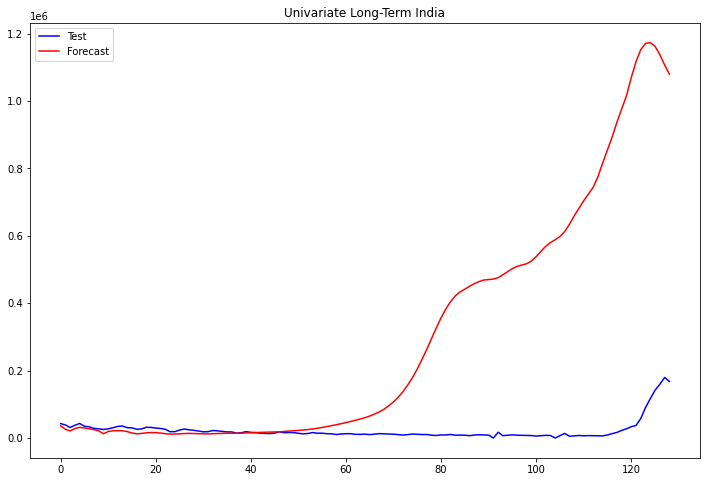

In [51]:
evaluate.plot_fore_test(india_uni_test_np_long_denorm, yhat_uni_india_long_denorm, 'Univariate Long-Term India')

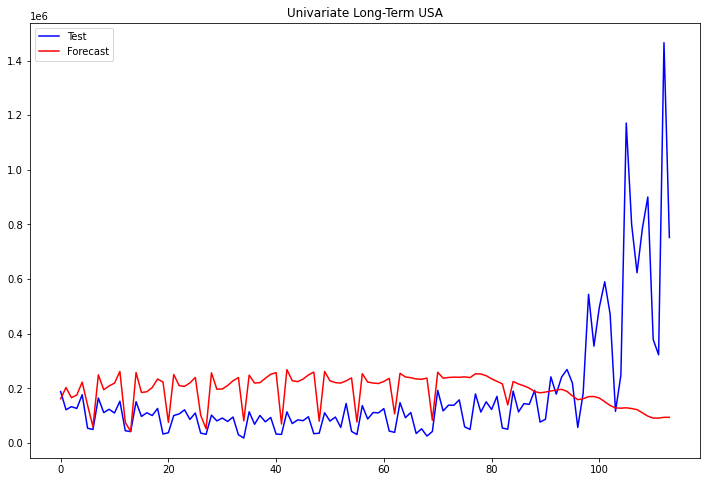

In [52]:
evaluate.plot_fore_test(usa_uni_test_np_long_denorm, yhat_uni_usa_long_denorm, 'Univariate Long-Term USA')

##### Multivariate

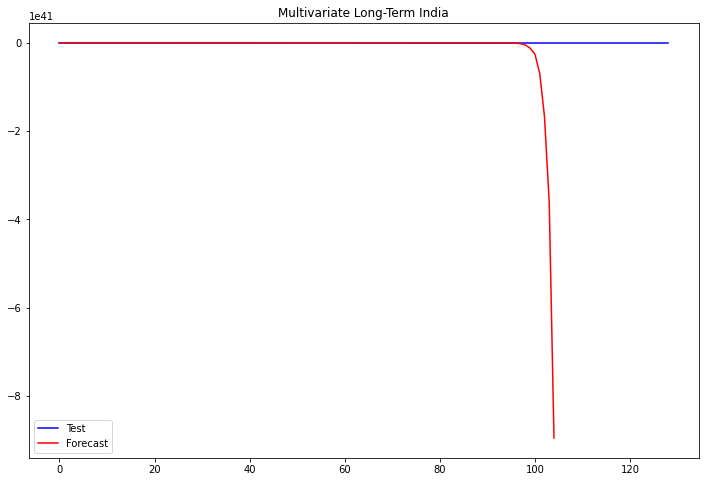

In [53]:
evaluate.plot_fore_test(india_multi_test_np_long_denorm, yhat_multi_india_long_denorm, "Multivariate Long-Term India")

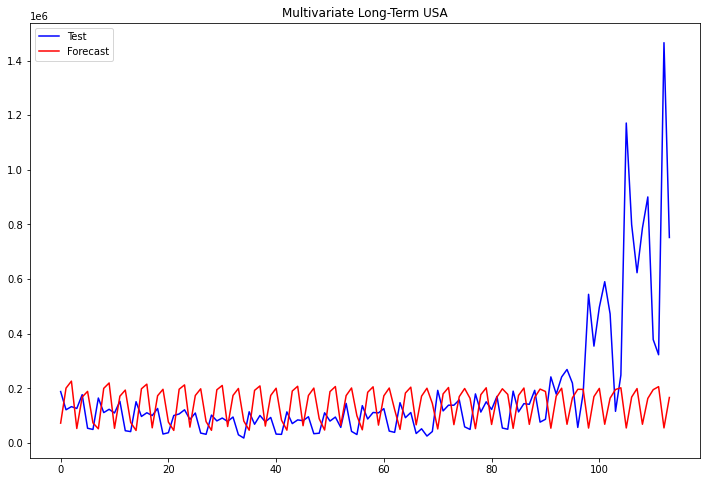

In [54]:
evaluate.plot_fore_test(usa_multi_test_np_long_denorm, yhat_multi_usa_long_denorm, "Multivariate Long-Term USA")

#### Short-Term Rolling Forecast

##### Univariate

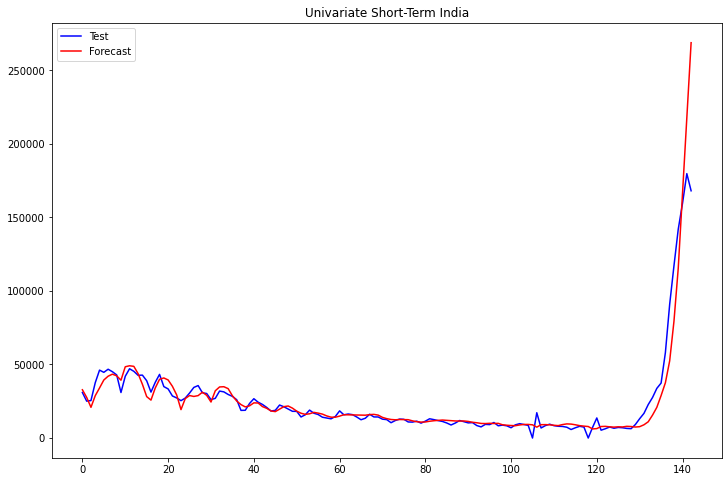

In [55]:
evaluate.plot_fore_test(india_uni_test_short_denorm, yhat_uni_india_short_denorm, "Univariate Short-Term India")

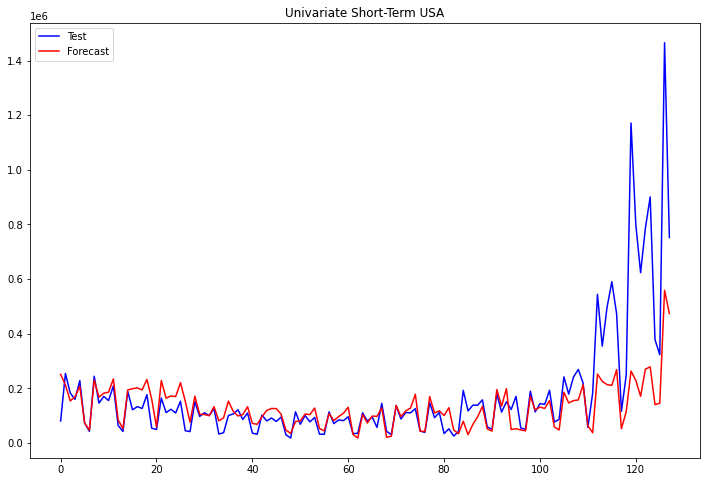

In [56]:
evaluate.plot_fore_test(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm, "Univariate Short-Term USA")

##### Multivariate

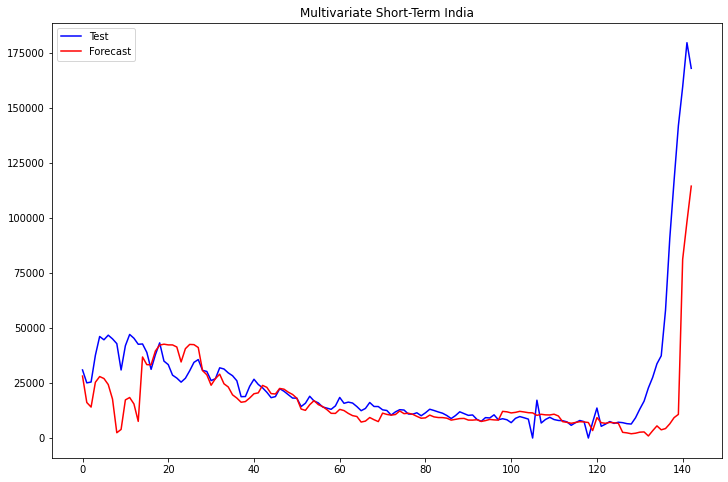

In [57]:
evaluate.plot_fore_test(india_multi_test_np_short_denorm, yhat_multi_india_short_denorm, "Multivariate Short-Term India")

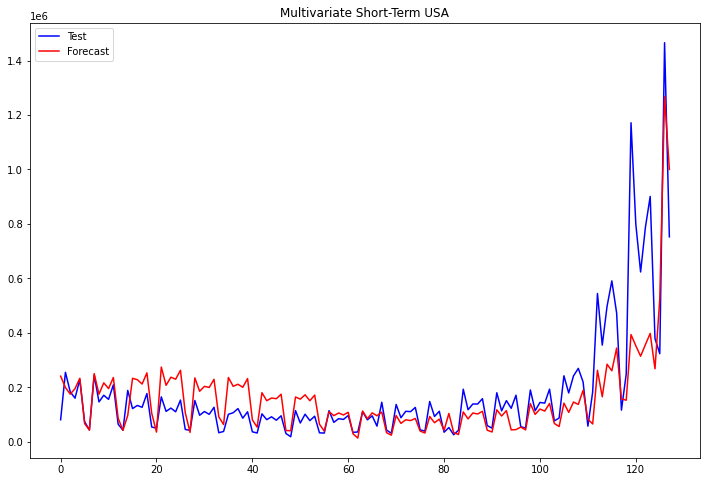

In [58]:
evaluate.plot_fore_test(usa_multi_test_np_short_denorm, yhat_multi_usa_short_denorm, "Multivariate Short-Term USA")

***
## Save Results
Split = 80:20
India has 568 train, 143 test
Usa has 511 train, 143 test

Long-term predictions have 14 less days in test

In [107]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
print("Parent Directory", parentDir)
figpath = os.path.join(parentDir,"../figures/lstm")

Parent Directory /covid19-prediction/models


In [108]:
import plotting

In [109]:
dates = india_cases_df.values[1:,0]
dates_df = pd.to_datetime(dates,format='%Y-%m-%d')
dates_df[-129:]

DatetimeIndex(['2021-09-04', '2021-09-05', '2021-09-06', '2021-09-07',
               '2021-09-08', '2021-09-09', '2021-09-10', '2021-09-11',
               '2021-09-12', '2021-09-13',
               ...
               '2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10'],
              dtype='datetime64[ns]', length=129, freq=None)

In [110]:
# Train values India
india_train_df = india_cases_df[['Date','Confirmed']][1:]
india_train_df['Date'] = pd.to_datetime(india_train_df['Date'],format='%Y-%m-%d')
india_train_df.set_index(['Date'],inplace=True)
india_train_df.loc['2021-03-01':]

,Confirmed
Date,
2021-03-01,12286.0
2021-03-02,14989.0
2021-03-03,17407.0
2021-03-04,16838.0
2021-03-05,18284.0
...,...
2022-01-06,117100.0
2022-01-07,141986.0
2022-01-08,159632.0


In [111]:
# Train values USA
usa_train_df = usa_cases_df[['Date','Confirmed']][1:]
usa_train_df['Date'] = pd.to_datetime(usa_train_df['Date'],format='%Y-%m-%d')
usa_train_df.set_index(['Date'],inplace=True)
usa_train_df

,Confirmed
Date,
2020-04-13,25255.0
2020-04-14,26694.0
2020-04-15,29318.0
2020-04-16,31235.0
2020-04-17,32175.0
...,...
2022-01-07,900832.0
2022-01-08,378732.0
2022-01-09,323142.0


#### Long-Term

In [112]:
# Univariate India

# Y values
y_india_uni_long_df = pd.DataFrame({'y_india_uni_long':india_uni_test_np_long_denorm})
y_india_uni_long_df.set_index(dates_df[-129:],inplace=True)
print(y_india_uni_long_df.head())

# yhat values
yhat_uni_india_long_df = pd.DataFrame({'yhat_india_uni_long':yhat_uni_india_long_denorm})
yhat_uni_india_long_df.set_index(dates_df[-129:],inplace=True)
print(yhat_uni_india_long_df.head())

            y_india_uni_long
2021-09-04           42766.0
2021-09-05           38948.0
2021-09-06           31222.0
2021-09-07           37875.0
2021-09-08           43263.0
            yhat_india_uni_long
2021-09-04              36203.0
2021-09-05              25996.0
2021-09-06              21038.0
2021-09-07              27939.0
2021-09-08              31846.0


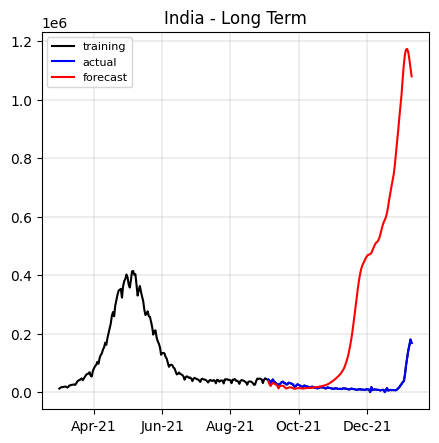

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [113]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_uni_long_df,fore=yhat_uni_india_long_df,
                              title='India - Long Term',figpath=figpath+'/india_unilstm.eps')

In [91]:
# Univariate USA

# Y values
y_usa_uni_long_df = pd.DataFrame({'y_usa_uni_long':usa_uni_test_np_long_denorm})
y_usa_uni_long_df.set_index(dates_df[-114:],inplace=True)
print(y_usa_uni_long_df.head())

# yhat values
yhat_uni_usa_long_df = pd.DataFrame({'yhat_usa_uni_long':yhat_uni_usa_long_denorm})
yhat_uni_usa_long_df.set_index(dates_df[-114:],inplace=True)
print(yhat_uni_usa_long_df.head())

            y_usa_uni_long
2021-09-19        188409.0
2021-09-20        121661.0
2021-09-21        133131.0
2021-09-22        126474.0
2021-09-23        176908.0
            yhat_usa_uni_long
2021-09-19           162011.0
2021-09-20           203108.0
2021-09-21           165992.0
2021-09-22           175763.0
2021-09-23           222942.0


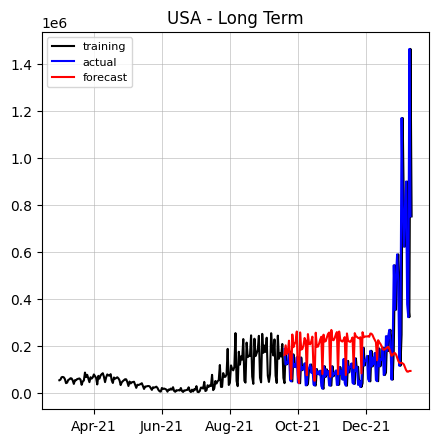

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [92]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_uni_long_df,fore=yhat_uni_usa_long_df,
                              title='USA - Long Term',figpath=figpath+'/usa_unilstm.eps')

In [93]:
# Multivariate India

# Y values
y_india_multi_long_df = pd.DataFrame({'y_india_multi_long':india_multi_test_np_long_denorm})
y_india_multi_long_df.set_index(dates_df[-129:],inplace=True)
print(y_india_multi_long_df.head())

# yhat values
yhat_multi_india_long_df = pd.DataFrame({'yhat_india_multi_long':yhat_multi_india_long_denorm})
yhat_multi_india_long_df.set_index(dates_df[-129:],inplace=True)
print(yhat_multi_india_long_df.head())

            y_india_multi_long
2021-09-04             42766.0
2021-09-05             38948.0
2021-09-06             31222.0
2021-09-07             37875.0
2021-09-08             43263.0
            yhat_india_multi_long
2021-09-04              -124413.0
2021-09-05               -83411.0
2021-09-06               -54709.0
2021-09-07               -93329.0
2021-09-08              -188111.0


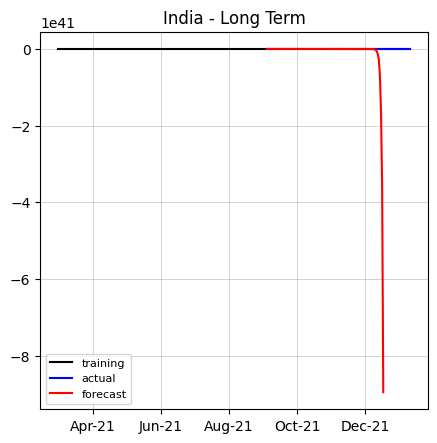

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [94]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_multi_long_df,fore=yhat_multi_india_long_df,
                              title='India - Long Term',figpath=figpath+'/india_multilstm.eps')

In [95]:
# Multivariate USA

# Y values
y_usa_multi_long_df = pd.DataFrame({'y_usa_multi_long':usa_multi_test_np_long_denorm})
y_usa_multi_long_df.set_index(dates_df[-114:],inplace=True)
print(y_usa_multi_long_df.head())

# yhat values
yhat_multi_usa_long_df = pd.DataFrame({'yhat_usa_multi_long':yhat_multi_usa_long_denorm})
yhat_multi_usa_long_df.set_index(dates_df[-114:],inplace=True)
print(yhat_multi_usa_long_df.head())

            y_usa_multi_long
2021-09-19          188409.0
2021-09-20          121661.0
2021-09-21          133131.0
2021-09-22          126474.0
2021-09-23          176908.0
            yhat_usa_multi_long
2021-09-19              72733.0
2021-09-20             200932.0
2021-09-21             226553.0
2021-09-22              53185.0
2021-09-23             168323.0


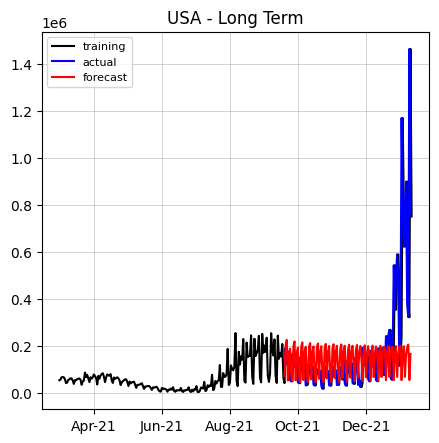

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [96]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_multi_long_df,fore=yhat_multi_usa_long_df,
                              title='USA - Long Term',figpath=figpath+'/usa_multilstm.eps')

#### Short-Term 

In [97]:
# Univariate India

# Y values
y_india_uni_short_df = pd.DataFrame({'y_india_uni_short':india_uni_test_short_denorm})
y_india_uni_short_df.set_index(dates_df[-143:],inplace=True)
print(y_india_uni_long_df.head())

# yhat values
yhat_uni_india_short_df = pd.DataFrame({'yhat_india_uni_short':yhat_uni_india_short_denorm})
yhat_uni_india_short_df.set_index(dates_df[-143:],inplace=True)
print(yhat_uni_india_short_df.head())

            y_india_uni_long
2021-09-04           42766.0
2021-09-05           38948.0
2021-09-06           31222.0
2021-09-07           37875.0
2021-09-08           43263.0
            yhat_india_uni_short
2021-08-21               32820.0
2021-08-22               27617.0
2021-08-23               20875.0
2021-08-24               28783.0
2021-08-25               34032.0


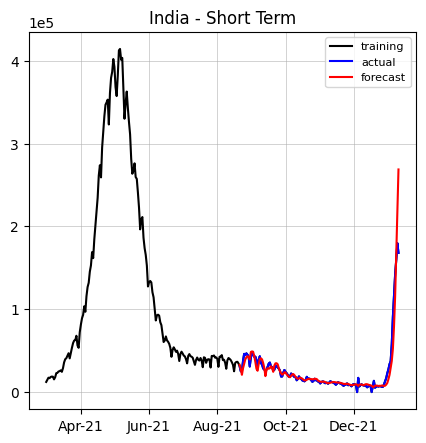

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [98]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_uni_short_df,fore=yhat_uni_india_short_df,
                              title='India - Short Term',figpath=figpath+'/india_unilstm_rolling.eps')

In [99]:
# Univariate USA

# Y values
y_usa_uni_short_df = pd.DataFrame({'y_usa_uni_short':usa_uni_test_short_denorm})
y_usa_uni_short_df.set_index(dates_df[-128:],inplace=True)
print(y_usa_uni_short_df.head())

# yhat values
yhat_uni_usa_short_df = pd.DataFrame({'yhat_usa_uni_short':yhat_uni_usa_short_denorm})
yhat_uni_usa_short_df.set_index(dates_df[-128:],inplace=True)
print(yhat_uni_usa_short_df.head())

            y_usa_uni_short
2021-09-05          80604.0
2021-09-06         254798.0
2021-09-07         183032.0
2021-09-08         159903.0
2021-09-09         228425.0
            yhat_usa_uni_short
2021-09-05            251365.0
2021-09-06            212566.0
2021-09-07            153907.0
2021-09-08            169123.0
2021-09-09            207977.0


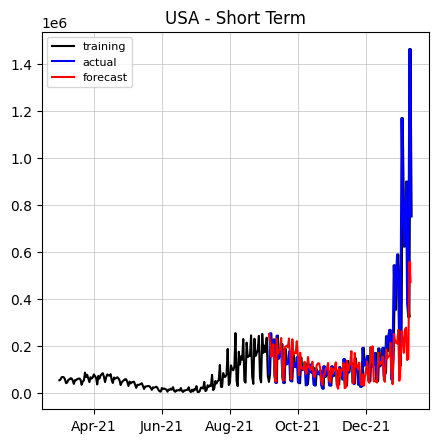

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [100]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_uni_short_df,fore=yhat_uni_usa_short_df,
                              title='USA - Short Term',figpath=figpath+'/usa_unilstm_rolling.eps')

In [101]:
# Multivariate India

# Y values
y_india_multi_short_df = pd.DataFrame({'y_india_multi_short':india_multi_test_np_short_denorm})
y_india_multi_short_df.set_index(dates_df[-143:],inplace=True)
print(y_india_multi_short_df.head())

# yhat values
yhat_multi_india_long_df = pd.DataFrame({'yhat_india_multi_short':yhat_multi_india_short_denorm})
yhat_multi_india_long_df.set_index(dates_df[-143:],inplace=True)
print(yhat_multi_india_long_df.head())

            y_india_multi_short
2021-08-21              30948.0
2021-08-22              25072.0
2021-08-23              25467.0
2021-08-24              37593.0
2021-08-25              46164.0
            yhat_india_multi_short
2021-08-21                 28164.0
2021-08-22                 16148.0
2021-08-23                 14080.0
2021-08-24                 25332.0
2021-08-25                 27949.0


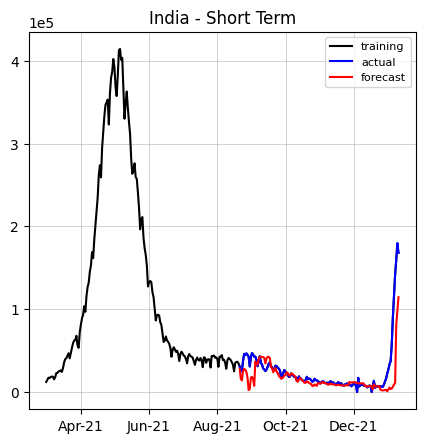

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [102]:
plotting.plot_train_test_fore(train=india_train_df,test=y_india_multi_short_df,fore=yhat_multi_india_long_df,
                              title='India - Short Term',figpath=figpath+'/india_multilstm_rolling.eps')

In [103]:
# Multivariate USA

# Y values
y_usa_multi_short_df = pd.DataFrame({'y_usa_multi_short':usa_multi_test_np_short_denorm})
y_usa_multi_short_df.set_index(dates_df[-128:],inplace=True)
print(y_usa_multi_short_df.head())

# yhat values
yhat_multi_usa_short_df = pd.DataFrame({'yhat_usa_multi_short':yhat_multi_usa_short_denorm})
yhat_multi_usa_short_df.set_index(dates_df[-128:],inplace=True)
print(yhat_multi_usa_short_df.head())

            y_usa_multi_short
2021-09-05            80604.0
2021-09-06           254798.0
2021-09-07           183032.0
2021-09-08           159903.0
2021-09-09           228425.0
            yhat_usa_multi_short
2021-09-05              240657.0
2021-09-06              199140.0
2021-09-07              174657.0
2021-09-08              194813.0
2021-09-09              232951.0


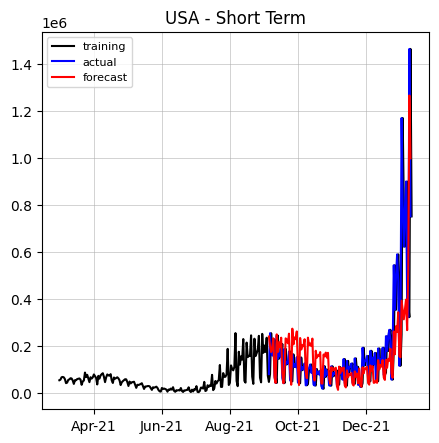

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [104]:
plotting.plot_train_test_fore(train=usa_train_df,test=y_usa_multi_short_df,fore=yhat_multi_usa_short_df,
                              title='USA - Short Term',figpath=figpath+'/usa_multilstm_rolling.eps')